# Allele Summaries

In the Introduction.ipynb, we started performing QC on the TRGTdb by looking at the number of loci analyzed by TRGT, the locus span distribution, alleles per-locus, etc. Here we'll make more detailed queries on alleles.

By the end of this notebook, you'll will know how to:
- calculate allele frequencies overall and within-populations
- identify allele length outliers
- measure the expansion/contraction length of alleles relative to the reference


In [1]:
import sys
import trgt
import truvari
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from IPython.display import display # Helps display pretty Tables

In [2]:
data = trgt.load_tdb("../test_files/databases/hprc_105.tdb/",
                    lfilters=[("chrom", "=", "chr4")]) # subsetting to run faster

# Allele counts

In the introduction we looked at the allele length distribution and number of alleles per-locus. Another useful, basic query is the analysis of how many  Let's start by looking at visualizing how many alleles there are per-locus.

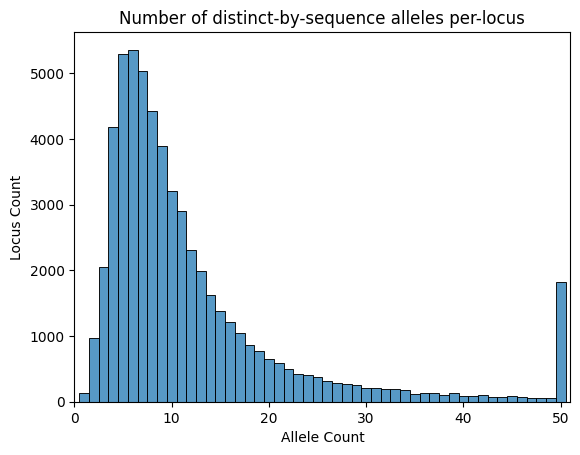

In [214]:
cnt = (data["allele"].groupby(["LocusID"]).size()
          .to_frame()
          .rename(columns={0:"Count"}))

# we'll bin all the loci with >50 alleles
bins = list(range(1, 51)) + [sys.maxsize]
cnt['CntBin'] = pd.cut(cnt["Count"], bins, right=False, labels=bins[:-1])

p = sb.histplot(data=cnt, x="CntBin", binwidth=1)
_ = p.set(title="Number of distinct-by-sequence alleles per-locus", 
          xlim=(0, 51), 
          xlabel="Allele Count",
          ylabel="Locus Count")

Because there may be SNPs or small sequence errors between alleles, our distinct-by-sequence may give an overestimate of allele counts since any difference between two alleles will cause them to be counted separately. One way to work around this is to consider two alleles at a locus with identical length as being the same.

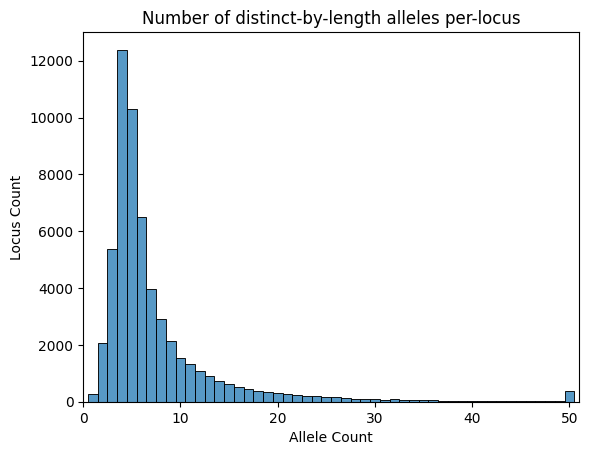

In [212]:
len_cnt = (data["allele"].groupby(["LocusID"])
              ["allele_length"].nunique()
              .to_frame()
              .rename(columns={"allele_length":"Count"}))

len_cnt['CntBin'] = pd.cut(len_cnt["Count"], bins, right=False, labels=bins[:-1])

p = sb.histplot(data=len_cnt, x="CntBin", binwidth=1)
_ = p.set(title="Number of distinct-by-length alleles per-locus", 
          xlim=(0, 51), 
          xlabel="Allele Count",
          ylabel="Locus Count")

# Allele frequency

Because this is a common measurement on alleles, the TRGTdb API has a baked in query to calculate allele frequencies (AF).

In [3]:
allele_freq = trgt.allele_count(data)
allele_freq.head()

,chrom,start,end,allele_number,AC,AF
LocusID,,,,,,
604481,chr4,16435,16520,0,135,0.649038
604481,chr4,16435,16520,3,40,0.192308
604481,chr4,16435,16520,1,18,0.086538
604481,chr4,16435,16520,5,5,0.024038
604481,chr4,16435,16520,2,4,0.019231


The `trgt.allele_count` query returns a new dataframe with two new columns

- AC : The allele count, or how many times the allele was observed across the samples
- AF : The allele frequency

The AF is calculated as `num_observation_of_allele / num_observations_at_locus`. The `num_observation_of_allele` is how many samples called the allele. The `num_observations_at_locus` is generally equal to `num_samples * 2` since each sample calls two alleles per-locus.

We can now check the distribution of these allele frequencies using seaborn (or whatever your favorite plotting tool may be).

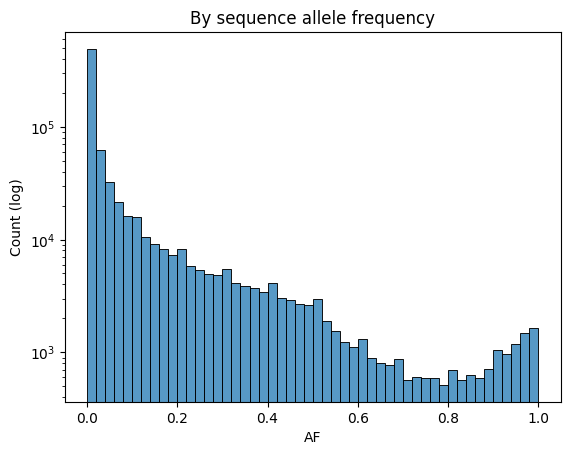

In [4]:
p = sb.histplot(data=allele_freq,
                x="AF", binwidth=0.02)
p.set(title="By sequence allele frequency", ylabel="Count (log)", yscale='log')
plt.show()

Our distribution has an unusual dip at AF between 0.5 and 1. This is because our `allele_freq` table includes the AF of loci's reference allele (`allele_number == 0`). Let's exclude separate the reference and alternate alleles and replot the AF distributions.

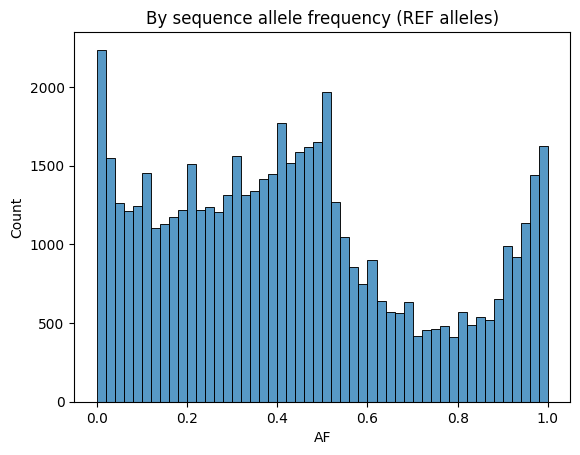

In [62]:
p = sb.histplot(data=allele_freq[allele_freq["allele_number"] == 0],
                x="AF", binwidth=0.02)
p.set(title="By sequence allele frequency (REF alleles)", ylabel="Count")
plt.show()

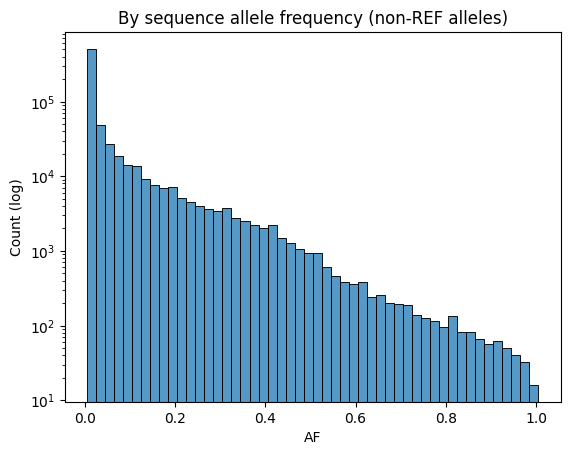

In [5]:
p = sb.histplot(data=allele_freq[allele_freq["allele_number"] != 0],
                x="AF", binwidth=0.02)
p.set(title="By sequence allele frequency (non-REF alleles)", ylabel="Count (log)", yscale='log')
plt.show()

Similarily, we can plot only the max allele frequency per-locus

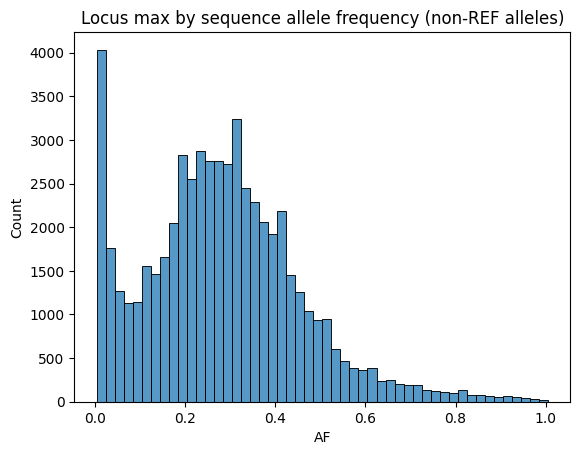

In [6]:
locus_max_af = (allele_freq[allele_freq["allele_number"] != 0]
                    .reset_index()
                    .groupby(['LocusID'])
                    ["AF"].max())

p = sb.histplot(data=locus_max_af, binwidth=0.02)
p.set(title="Locus max by sequence allele frequency (non-REF alleles)", ylabel="Count")#, yscale='log')
plt.show()

As mentioned above, we may also be interseted in considering alleles of the same length as the same.

In [7]:
allele_freq_bylen = trgt.allele_count_length(data)
allele_freq_bylen.head()

,chrom,start,end,is_ref,allele_length,AC,AF
LocusID,,,,,,,
604481,chr4,16435,16520,True,85,135,0.649038
604481,chr4,16435,16520,False,89,40,0.192308
604481,chr4,16435,16520,False,87,19,0.091346
604481,chr4,16435,16520,False,91,7,0.033654
604481,chr4,16435,16520,False,83,4,0.019231


Since we've consolidated alleles by their length, they no longer have an allele_number that identifies the reference allele. Therefore, the `trgt.allele_count_length` query adds the column `is_ref` which identifies the reference allele's length. All alternate alleles of this same length are counted with the `is_ref` allele.

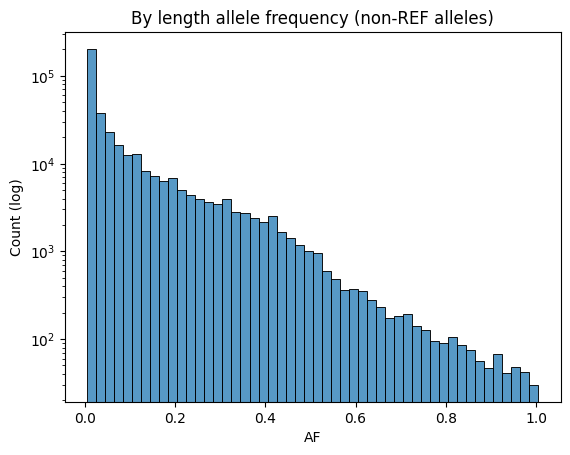

In [13]:
p = sb.histplot(data=allele_freq_bylen[~allele_freq_bylen['is_ref']],
                x="AF", binwidth=0.02)
p.set(title="By length allele frequency (non-REF alleles)", ylabel="Count (log)", yscale='log')
plt.show()

# Allele frequency by population

Calculating the AF over an entire population is one thing, but some use-cases may call for calculating an intra-population AF. To accomplish this, we can take advantage of the `samples` parameter for our `allele_counts` queries. 

ToDo: I'm just using https://www.internationalgenome.org/data-portal/sample to pull super-population. This metadata doesn't map to all of the hprc_105 samples. So, we'll need to collect that.

In [9]:
metadata = pd.read_csv("../test_files/igsr_samples.tsv", sep='\t')
hprc_metadata = metadata[metadata["Sample name"].isin(data["sample"].keys())]

In [10]:
hprc_metadata["Superpopulation code"].value_counts()

AMR    29
AFR    28
SAS    24
EAS    16
Name: Superpopulation code, dtype: int64

Since there's a similar count of AMR and AFR samples, we'll compare their intra-pop AF.

In [11]:
amr_samp_names = hprc_metadata[hprc_metadata["Superpopulation code"] == "AMR"]["Sample name"]
amr_af = trgt.allele_count_length(data, samples=amr_samp_names)

afr_samp_names = hprc_metadata[hprc_metadata["Superpopulation code"] == "AFR"]["Sample name"]
afr_af = trgt.allele_count_length(data, samples=afr_samp_names)
                                  

We'll concatenate the two AF results and `dropna` so that we're only looking at alleles found in both populations. 

Note that because the two AF results have redundant columns, we're first going to clean up the column names using `DataFrame.rename` and `DataFrame.drop`. 

Also note that when doing the concatenation, we set the index to both the LocusID and allele_length since we used `trgt.allele_count_length` to consolidate alleles of identical length. Therefore the length of the allele is its unique identifier. 

In [21]:
afr_af = (afr_af.reset_index()
              .set_index(["LocusID", "allele_length"])
              .rename(columns={"AC": "AFR_AC", "AF": "AFR_AF"}))
amr_af = (amr_af.reset_index()
              .set_index(["LocusID", "allele_length"])
              .rename(columns={"AC": "AMR_AC", "AF": "AMR_AF"})
              .drop(columns=["chrom", "start", "end", "is_ref"])) # These are preserved in the afr_af table

pop_af = pd.concat([afr_af, amr_af], axis=1).dropna()

pop_af.head()

chrom    start      end is_ref  AFR_AC    AFR_AF  \
LocusID allele_length                                                    
604481  85             chr4  16435.0  16520.0   True    37.0  0.660714   
        87             chr4  16435.0  16520.0  False     8.0  0.142857   
        89             chr4  16435.0  16520.0  False     8.0  0.142857   
604482  97             chr4  83594.0  83691.0   True    17.0  0.303571   
        98             chr4  83594.0  83691.0  False    10.0  0.178571   

                       AMR_AC    AMR_AF  
LocusID allele_length                    
604481  85               39.0  0.672414  
        87                5.0  0.086207  
        89               14.0  0.241379  
604482  97               24.0  0.413793  
        98               18.0  0.310345

For fun, let's find some alleles that occur in both populations, but at drastically different frequencies. This likely isn't an informative analysis, so be careful not to over-interpret the results.

In [28]:
def population_bin(x):
    """
    returns a label for which population has the allele more frequently
    """
    if x < -0.10:
        return "AMR"
    if x > 0.10:
        return "AFR"
    return "SAME"

pop_af["AF_diff"] = pop_af["AFR_AF"] - pop_af["AMR_AF"]
pop_af["AF_diff_bin"] = pop_af["AF_diff"].apply(population_bin)

pop_af["AF_diff_bin"].value_counts()

SAME    164729
AMR      38345
AFR      31117
Name: AF_diff_bin, dtype: int64

We've found ~70k alleles which occur more frequently in one population over the other.

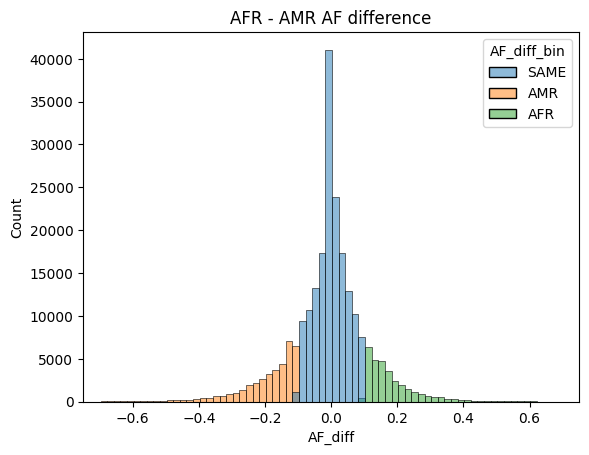

In [30]:
p = sb.histplot(data=pop_af, x="AF_diff", hue="AF_diff_bin", binwidth=0.02)
p.set(title="AFR - AMR AF difference", xlim=(-0.75, 0.75))
plt.show()

And if we want to pull the loci where we observed a large intra-pop AF difference: 

In [59]:
loci = data["locus"].set_index("LocusID")
subset = (loci.loc[(pop_af[pop_af["AF_diff_bin"].isin(["AMR", "AFR"])]
                    .reset_index()["LocusID"])
                    .sort_values()
                    .drop_duplicates()])
n_loci = len(subset)
pct_loci = n_loci / len(loci) * 100
print(f"{n_loci:,} ({pct_loci:.1f}%) loci have an allele with intra-pop AF differences")
subset.head()

34,995 (61.5%) loci have an allele with intra-pop AF differences


,chrom,start,end
LocusID,,,
604482,chr4,83594,83691
604483,chr4,87691,87763
604484,chr4,82347,82425
604487,chr4,79651,79724
604488,chr4,89873,89995


# Allele length outliers

TODO

# Allele variant lengths

TRGT reports alleles as 'blocks' of the genome such that their `allele_length` shouldn't be confused with a `variant_length`. For example, imagine we have a locus that spans 100bp and has an alternate allele that is 150bp long. This alternate allele's `variant_length` is an expansion of 50bp. We can calculate this by sending our allele table to the `trgt.variant_length` query.

In [44]:
# We'll make a copy of the allele table so that adding/removing columns won't alter 
# the in-memory tdb. It wouldn't be a problem (usually) if we did add columns to it.
# But it's generally a good practice to only manipulate copies.
allele = data["allele"].copy()

allele['variant_length'] = trgt.variant_length(data["allele"])

def set_variant_type(length):
    """
    Return if an allele is an expansion, contraction, or of the same length (ref) as the reference
    """
    if length < 0:
        return "CON"
    if length > 0:
        return "EXP"
    return 'REF'
allele['variant_type'] = allele['variant_length'].apply(set_variant_type)

# Truvari has a convenience function for binning variants by size
# so let's grab that, too
import truvari 

allele['sizebin'] = (allele["variant_length"].abs()
                         .apply(lambda x: truvari.get_sizebin(x))
                         .astype(truvari.SZBINTYPE)) # helps sort the categorical variable

allele.head()

,LocusID,allele_number,allele_length,sequence,variant_length,variant_type,sizebin
0,604481,0,85,TTACTATGAGATTGCTATCCACTATTTATATGTGTGTGTGTGTGTG...,0,REF,SNP
1,604481,1,87,TTACTATGAGATTGCTATCCACTATTTATATGTGTGTGTGTGTGTG...,2,EXP,"[1,5)"
2,604481,2,83,TTACTATGAGATTGCTATCCACTATTTATATGTGTGTGTGTGTGTG...,-2,CON,"[1,5)"
3,604481,3,89,TTACTATGAGATTGCTATCCACTATTTATATGTGTGTGTGTGTGTG...,4,EXP,"[1,5)"
4,604481,4,93,TTACTATGAGATTGCTATCCACTATTTATATGTGTGTGTGTGTGTG...,8,EXP,"[5,10)"


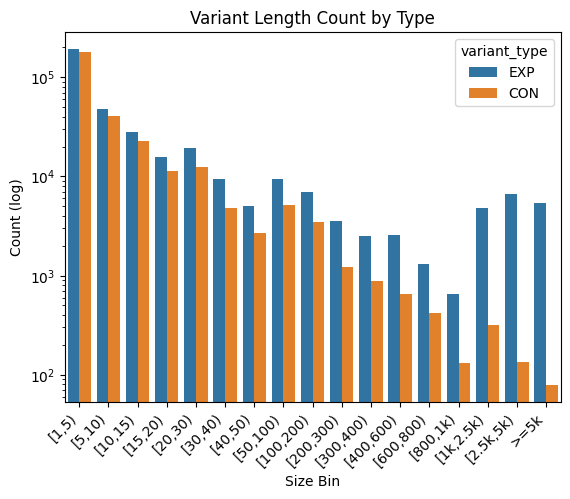

In [46]:
p = sb.countplot(data=allele[allele['variant_type'] != 'REF'],
                 x="sizebin",
                 hue="variant_type",
                 order=truvari.SZBINS[1:])
plt.xticks(rotation=45, ha='right') # Cleans up the xtick labels
p.set(title="Variant Length Count by Type", 
      xlabel="Size Bin", 
      ylabel="Count (log)",
      yscale="log")
plt.show()